<a href="https://colab.research.google.com/github/fadialutfiya/yolo-fruit-detection/blob/main/Fruit_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deteksi Buah Menggunakan Deep Learning (YOLO)

*Overview*

Projek ini merupakan sebuah projek Computer Vision dimana model dilatih menggunakan tiga gambar buah (Apel, Pisang, dan Jeruk). Dataset yang digunakan diambil dari Kaggle:

https://www.kaggle.com/datasets/mbkinaci/fruit-images-for-object-detection

Dataset ini terdiri atas 600 files: 300 data gambar buah, 300 data bounding box. Bounding box adalah sebuah 'kotak' yang menunjukkan letak objek (dalam kasus ini, buah-buahan).

Projek ini menggunakan YOLOv8 (You Only Look Once ver. 8), salah satu algoritma yang umum dipakai untuk deteksi objek. Algoritma di-impor dari library Ultralytics.

# Data Preparation
**1. Cek GPU (Graphics Processing Unit)**

Untuk mempermudah/mempercepat proses latih, digunakan GPU Google Colab. Caranya yaitu dengan mengganti tipe runtime menjadi GPU lalu jalankan kode berikut untuk mengecek apakah sudah switch ke GPU atau belum.

In [ ]:
!nvidia-smi

Sat May 31 22:44:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**2. Upload dataset**

Dataset di-upload melalui penyimpanan sementara Google Colab. Dataset diupload dalam bentuk zip dan diekstrak menggunakan kode di bawah.

File ini berisi dua folder: images yang berisi gambar buah-buahan, dan folder labels yang berisi file anotasi atau bounding box (XML). Selain itu, juga terdapat file TXT yang berisi classes.

In [ ]:
!unzip -q /content/fruit_detect.zip -d /content/custom_data

**3. Mengubah format bounding box**

Format file anotasi (bounding box) yang dapat dibaca YOLO adalah .txt, sedangkan dataset yang kita miliki sekarang masih berformat .xml. Oleh karena itu, kita akan mengubah format tersebut menggunakan library os, xml.etree.ElementTree, dan OpenCV.

File yang menjadi input adalah file labels yang berisi file anotasi berformat .xml, dan hasil konversi nanti akan dimasukkan ke file baru yang bernama label. Pada kode ini, kita juga memasukkan jumlah class (yang dimana ada empat: apple, banana, mixed, dan orange').

Digunakan loop untuk mengecek satu persatu dari file anotasi. Jika pada file anotasi .xml tidak ditemukan ukuran bounding box-nya, kode akan membaca langsung dari gambarnya.



In [ ]:
import os
import xml.etree.ElementTree as ET
import cv2

input_dir = '/content/custom_data/labels'
output_label_dir = os.path.join(input_dir, 'label')
image_dir =  '/content/custom_data/images'

os.makedirs(output_label_dir, exist_ok=True)
class_list = ['apple', 'banana', 'mixed', 'orange']

for file in os.listdir(input_dir):
    if file.endswith('.xml'):
        xml_path = os.path.join(input_dir, file)
        tree = ET.parse(xml_path)
        root = tree.getroot()

        filename = root.find('filename').text
        image_path = os.path.join(image_dir, filename)

        # Ambil size dari file XML
        width = int(root.find('size/width').text)
        height = int(root.find('size/height').text)

        # Jika width/height = 0, baca dari file .jpg-nya
        if width == 0 or height == 0:
            if not os.path.exists(image_path):
                print(f"⚠️ Gambar {image_path} tidak ditemukan. Skipping")
                continue
            img = cv2.imread(image_path)
            height, width, _ = img.shape

        yolo_lines = []
        for obj in root.findall('object'):
            class_name = obj.find('name').text.lower()
            if class_name not in class_list:
                continue

            class_id = class_list.index(class_name)
            bbox = obj.find('bndbox')
            xmin = int(float(bbox.find('xmin').text))
            ymin = int(float(bbox.find('ymin').text))
            xmax = int(float(bbox.find('xmax').text))
            ymax = int(float(bbox.find('ymax').text))

            x_center = ((xmin + xmax) / 2) / width
            y_center = ((ymin + ymax) / 2) / height
            w = (xmax - xmin) / width
            h = (ymax - ymin) / height

            yolo_line = f"{class_id} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}"
            yolo_lines.append(yolo_line)

        txt_filename = file.replace('.xml', '.txt')
        txt_path = os.path.join(output_label_dir, txt_filename)

        with open(txt_path, 'w') as f:
            f.write('\n'.join(yolo_lines))

print("✅ Conversion selesai. Cek folder:", output_label_dir)


✅ Conversion selesai. Cek folder: /content/custom_data/labels/label


**4. Split train dan test data**

YOLO membutuhkan struktur data tertentu. Untuk mengatasi hal tersebut, kita menggunakan sebuah script yang di-import dari GitHub dimana script ini dapat melakukan splitting data (90% train dan 10% test) dan mengatur struktur data sesuai standar YOLO secara langsung. Hasil splitting ini akan disimpan pada folder custom_data yang berisi hasil unzip dataset tadi.

In [ ]:
!wget -O /content/train_val_split.py https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py

!python train_val_split.py --datapath="/content/custom_data" --train_pct=0.9

--2025-05-31 22:48:46--  https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3203 (3.1K) [text/plain]
Saving to: ‘/content/train_val_split.py’

/content/train_val_ 100%[===================>]   3.13K  --.-KB/s    in 0s      

2025-05-31 22:48:46 (60.2 MB/s) - ‘/content/train_val_split.py’ saved [3203/3203]

Created folder at /content/data/train/images.
Created folder at /content/data/train/labels.
Created folder at /content/data/validation/images.
Created folder at /content/data/validation/labels.
Number of image files: 300
Number of annotation files: 300
Images moving to train: 270
Images moving to validation: 30


**5. Install library yang diperlukan (Ultralytics)**

Untuk menggunakan YOLO, kita akan meng-install library Ultralytics.

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

**6. Generate file YAML**

Sebelum ke tahap training, YOLO membutuhkan sebuah file YAML untuk dapat membaca data secara langsung. YAML (YAML Ain't Markup Language) merupakan sebuah bahasa serialisasi data yang dirancang untuk membantu menyimpan data dalam format yang mudah dipahami dan dibaca.

Untuk menghasilkan file YAML ini, kode akan membaca file classes.txt yang sudah ada untuk menentukan kelas apa saja yang digunakan. Lalu kode juga akan menentukan path ke folder training dan test.

File YAML akan ditambahkan ke folder untuk dibaca oleh model.

In [ ]:
import yaml
import os

def create_data_yaml(path_to_classes_txt, path_to_data_yaml):

  # Membaca file classes.txt untuk mengambil kelas
  if not os.path.exists(path_to_classes_txt):
    print(f'classes.txt file not found! Please create a classes.txt labelmap and move it to {path_to_classes_txt}')
    return
  with open(path_to_classes_txt, 'r') as f:
    classes = []
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      classes.append(line.strip())
  number_of_classes = len(classes)

  # Membuat isi file YAML
  data = {
      'path': '/content/data',
      'train': 'train/images',
      'val': 'validation/images',
      'nc': number_of_classes,
      'names': classes
  }

  # Memasukkan data ke dalam file YAML3
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print(f'Created config file at {path_to_data_yaml}')

  return

path_to_classes_txt = '/content/custom_data/classes.txt'
path_to_data_yaml = '/content/data.yaml'

create_data_yaml(path_to_classes_txt, path_to_data_yaml)

# Cek isi file YAML
print('\nFile contents:\n')
!cat /content/data.yaml

Created config file at /content/data.yaml

File contents:

path: /content/data
train: train/images
val: validation/images
nc: 4
names:
- apple
- banana
- mixed
- orange


# Training Model

**1. Menjalankan training menggunakan YOLOv8**

Model YOLO dipanggil dari library Ultralytics dengan jenis train 'detect' yang artinya model ini akan digunakan untuk deteksi objek. Versi model yang digunakan adalah YOLOv8 dengan Epochs sebanyak 40 (karena jumlah data yang terhitung cukup kecil).

In [ ]:
!yolo detect train data=/content/data.yaml model=yolov8s.pt epochs=40 imgsz=640

100% 21.5M/21.5M [00:00<00:00, 225MB/s]
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plo

**2. Test Model**

Setelah training, dilakukan test.

In [ ]:
!yolo detect predict model=runs/detect/train/weights/best.pt source=data/validation/images save=True

Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs

image 1/30 /content/data/validation/images/apple_10.jpg: 640x640 1 apple, 16.3ms
image 2/30 /content/data/validation/images/apple_19.jpg: 480x640 2 apples, 39.3ms
image 3/30 /content/data/validation/images/apple_23.jpg: 640x640 3 apples, 17.2ms
libpng warning: iCCP: known incorrect sRGB profile
image 4/30 /content/data/validation/images/apple_28.jpg: 640x640 1 apple, 16.2ms
image 5/30 /content/data/validation/images/apple_39.jpg: 384x640 1 apple, 38.0ms
image 6/30 /content/data/validation/images/apple_58.jpg: 640x576 3 apples, 37.8ms
image 7/30 /content/data/validation/images/apple_66.jpg: 480x640 2 apples, 14.6ms
image 8/30 /content/data/validation/images/apple_75.jpg: 640x640 1 apple, 16.9ms
image 9/30 /content/data/validation/images/apple_76.jpg: 512x640 1 apple, 40.6ms
image 10/30 /content/data/validation/images/apple_

**3. Mengecek hasil model**

Kode ini digunakan untuk mengecek hasil training model. Outputnya berupa gambar buah dengan bounding box-nya.

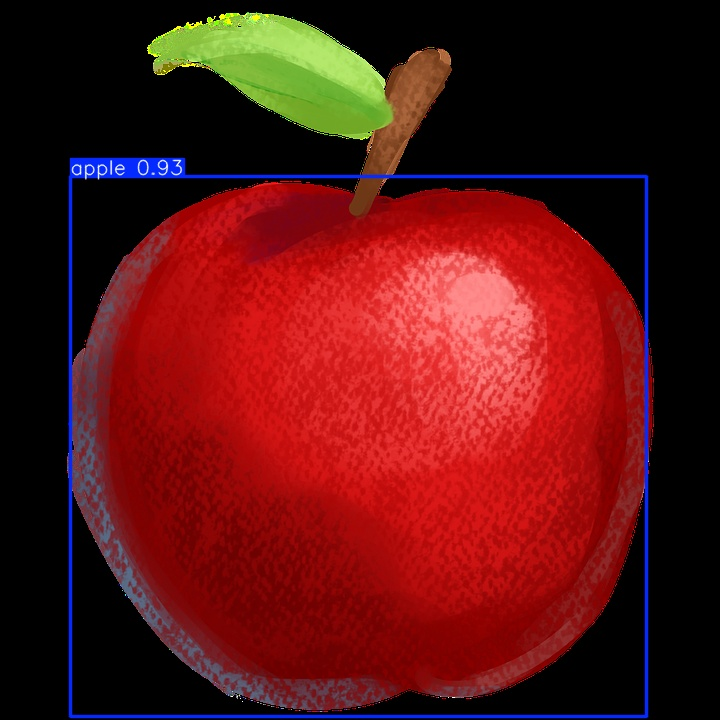

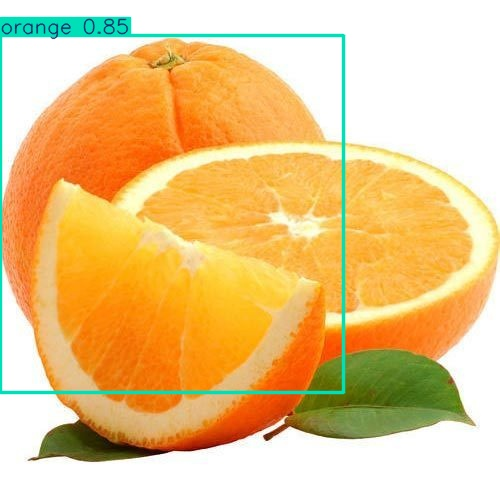

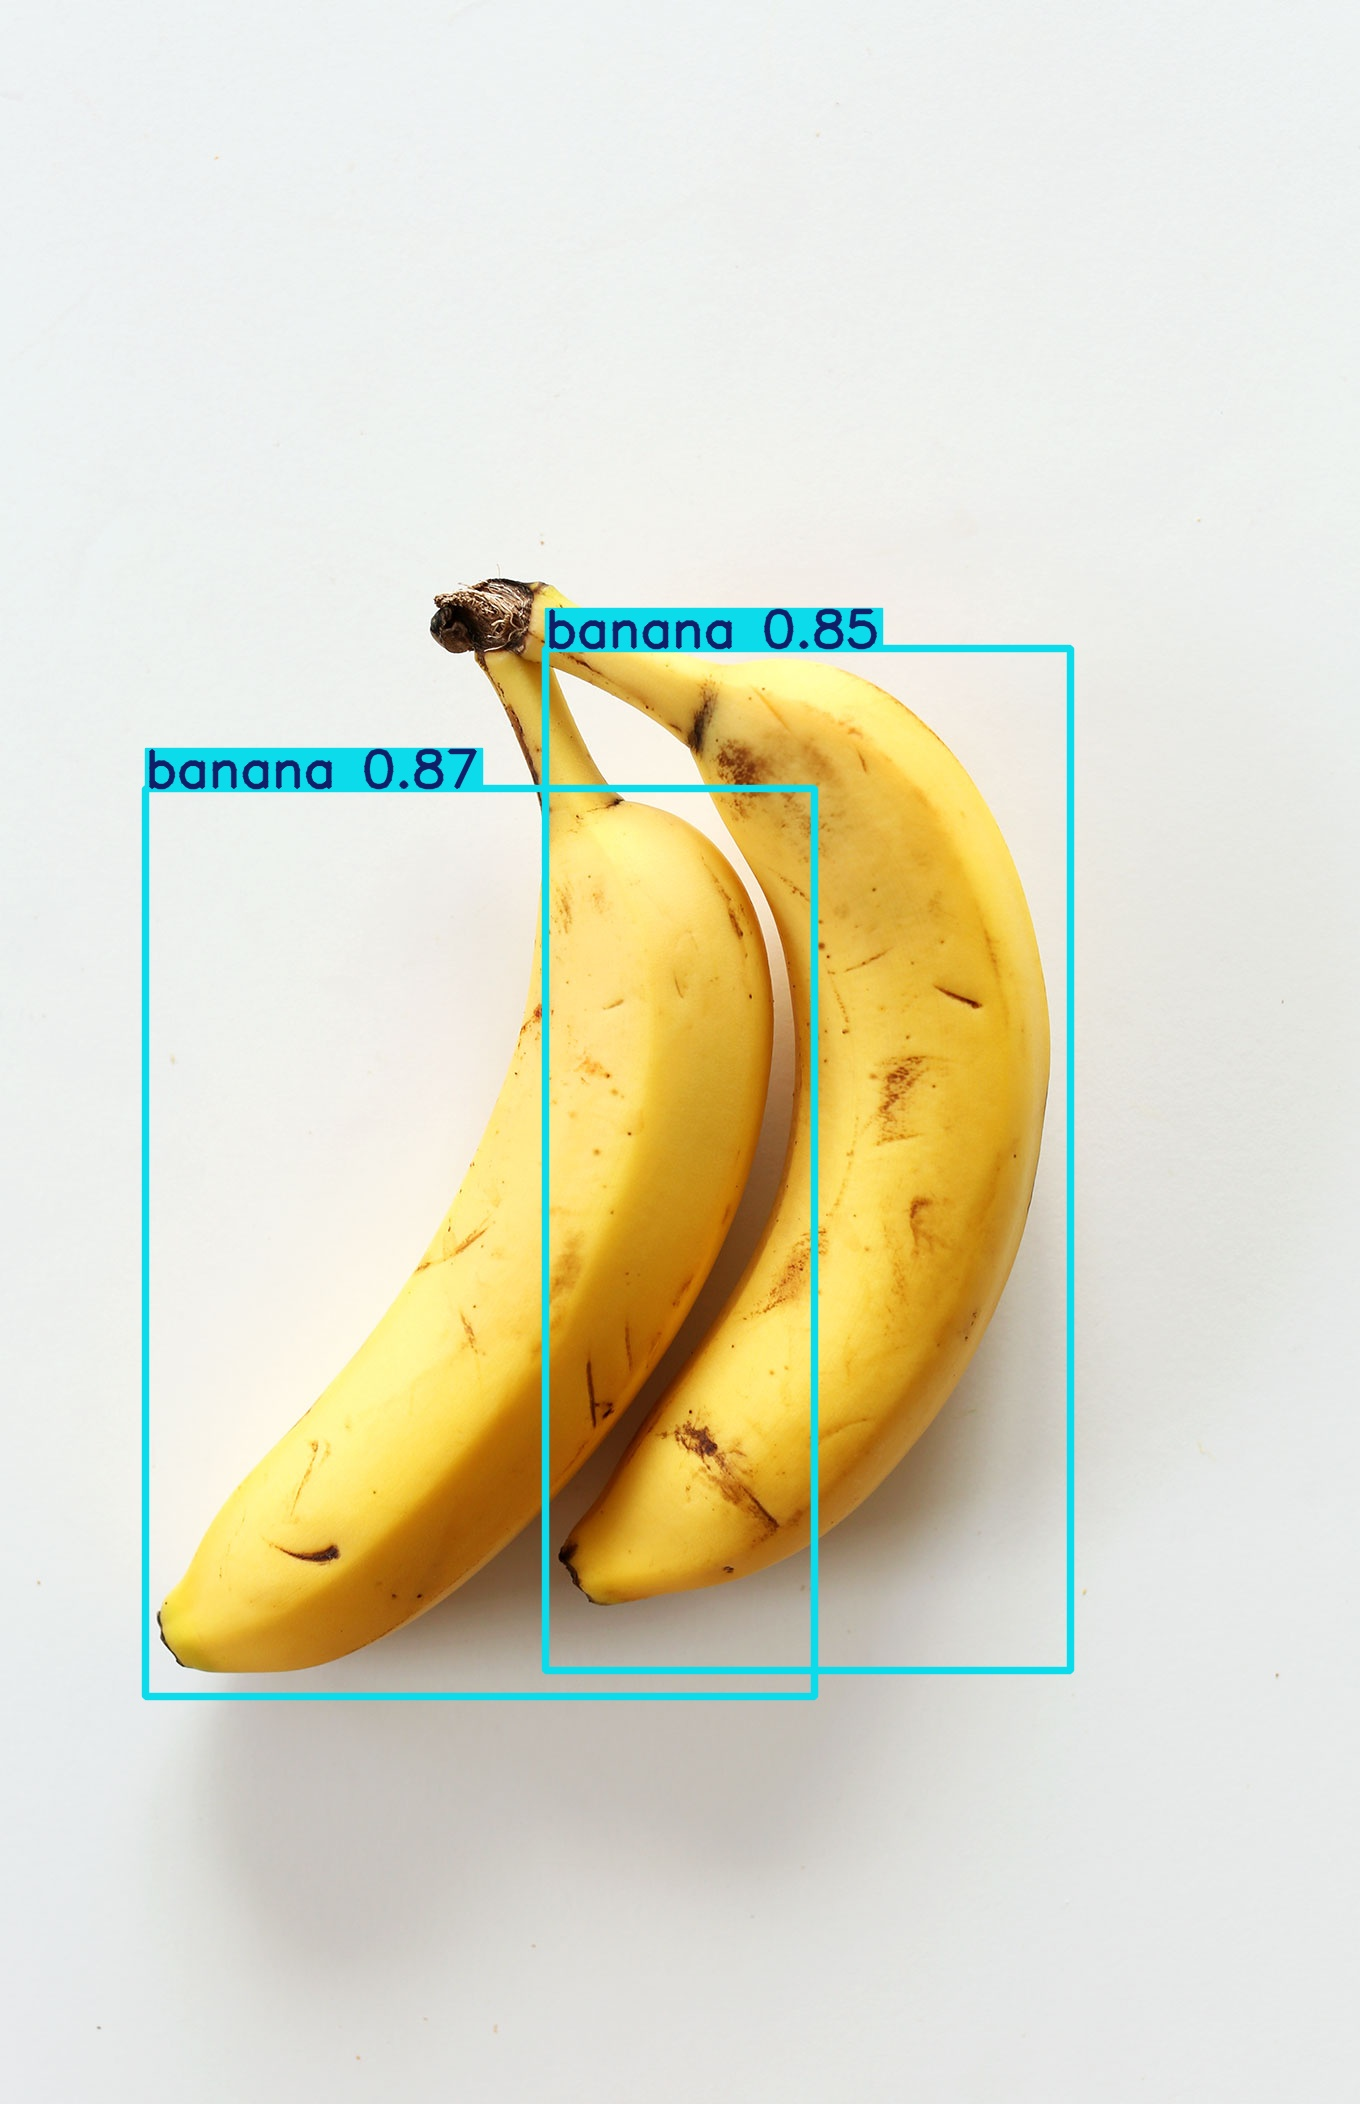

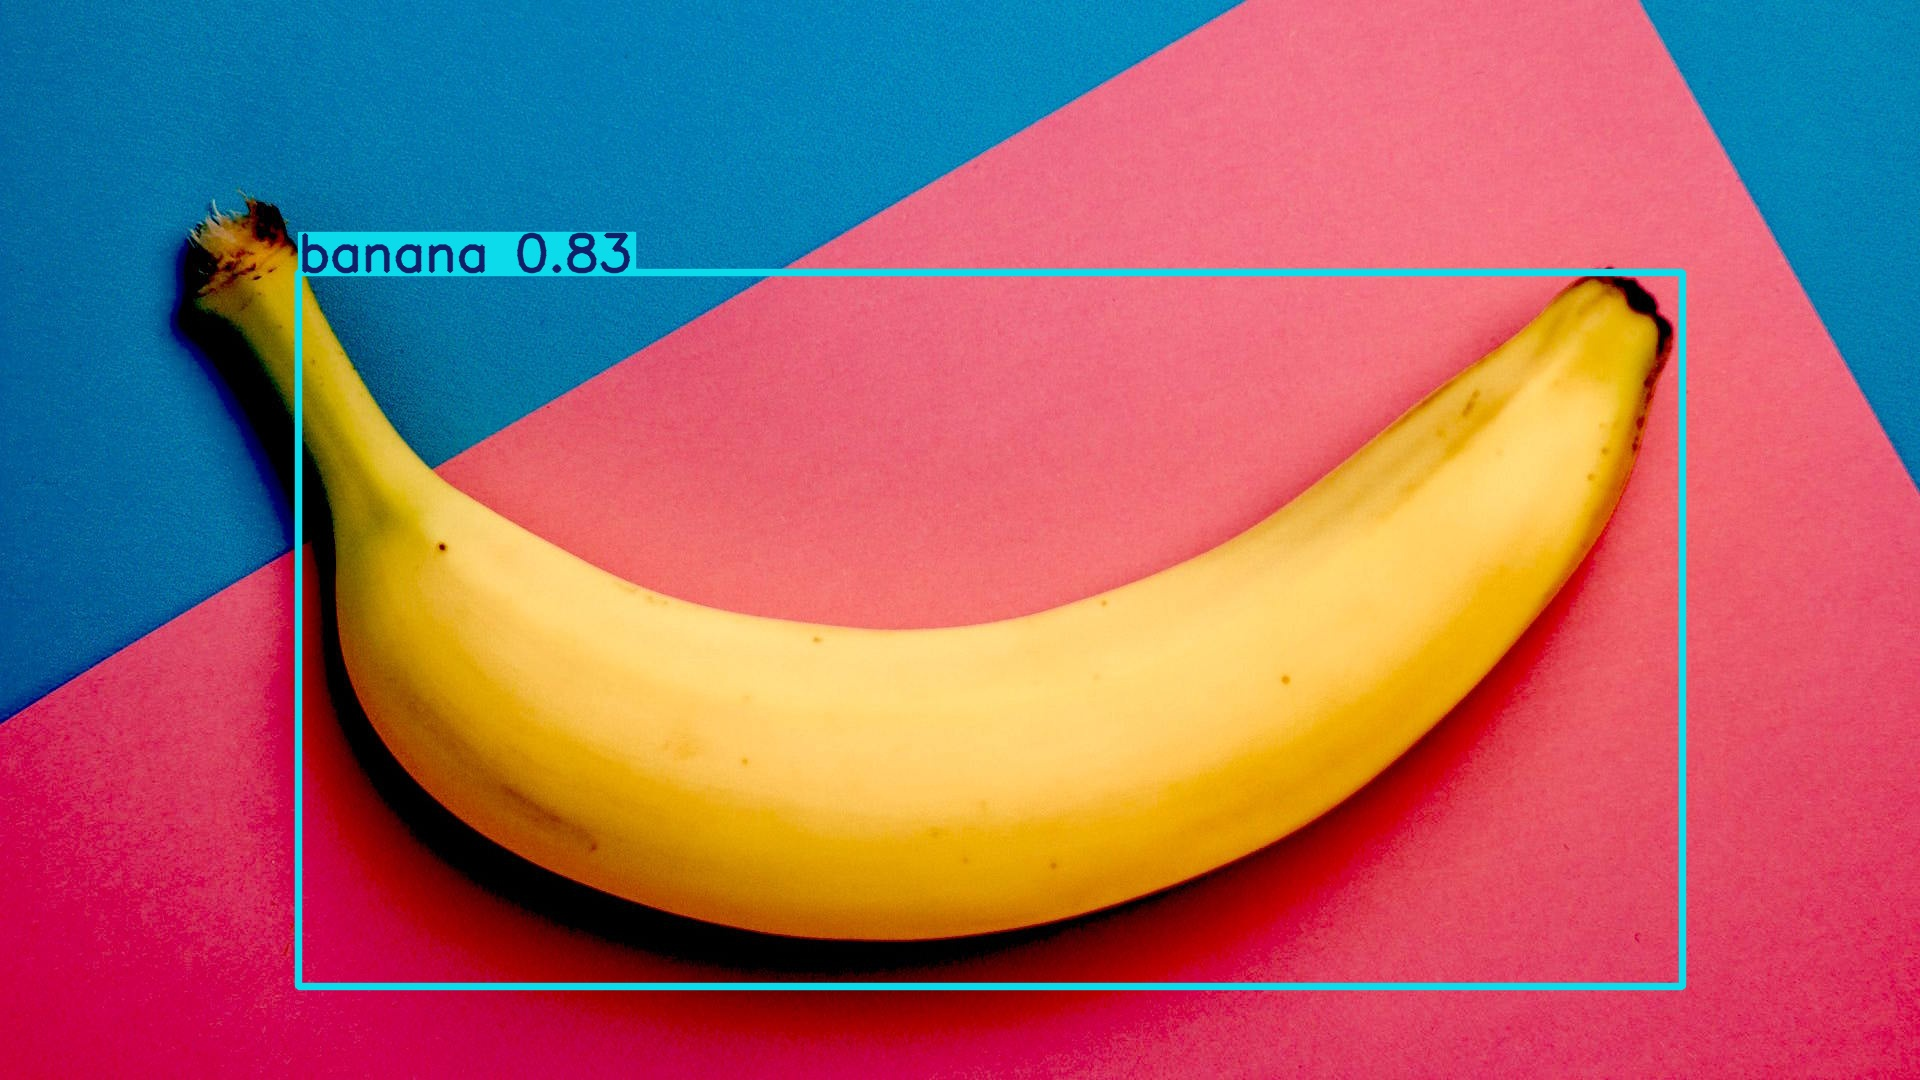

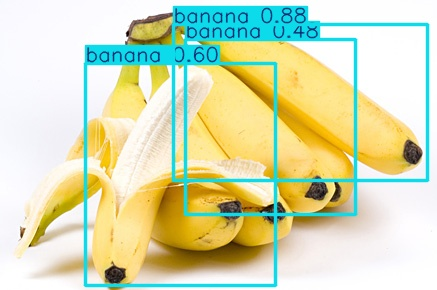

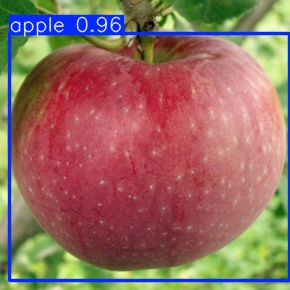

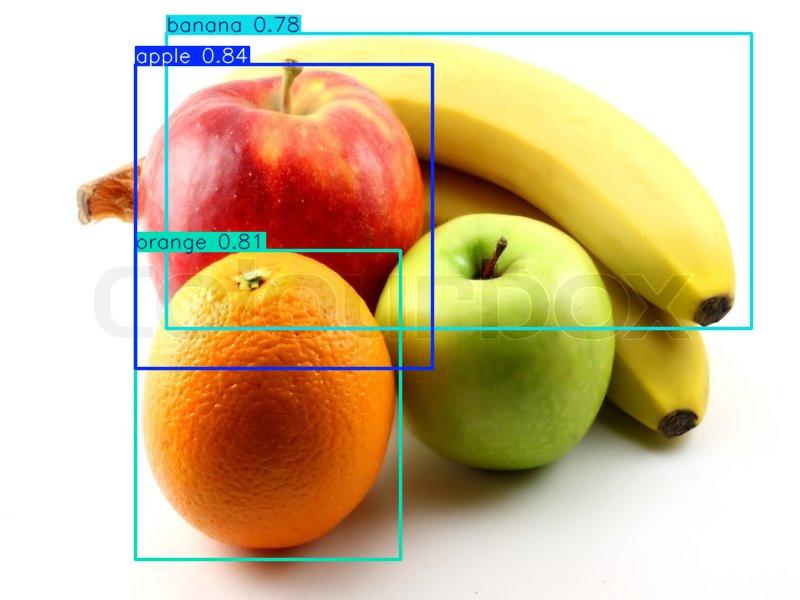

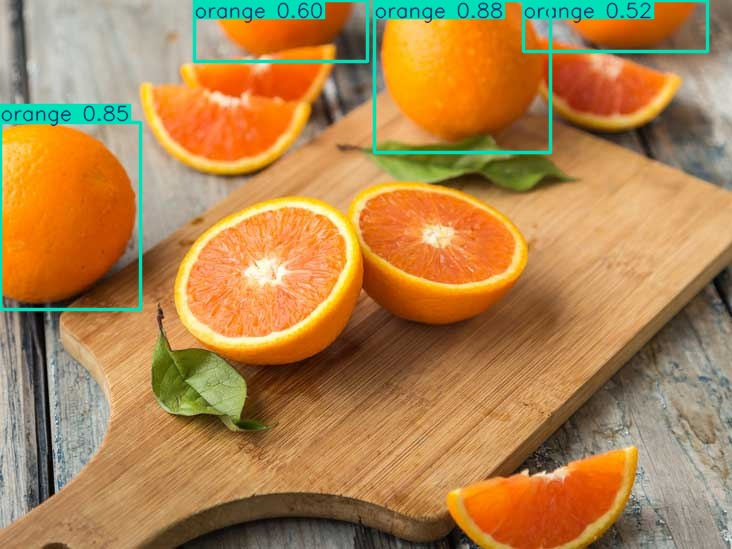

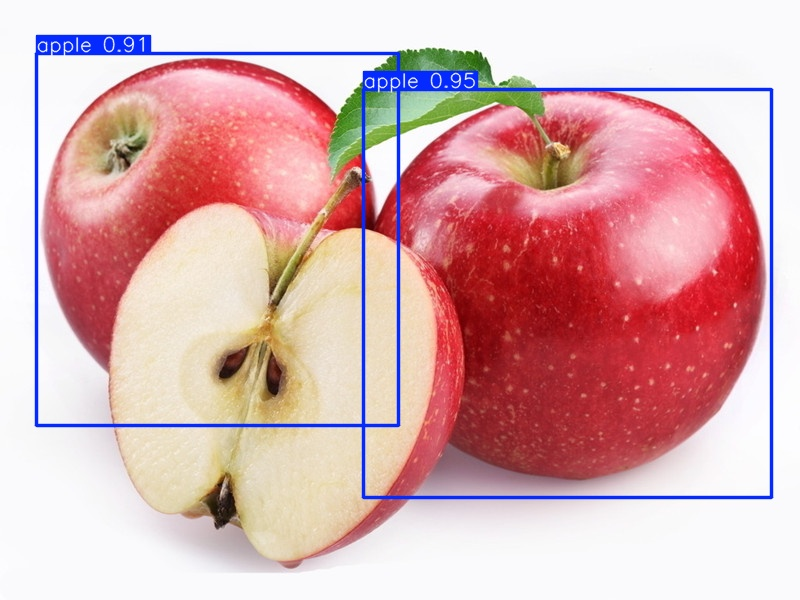

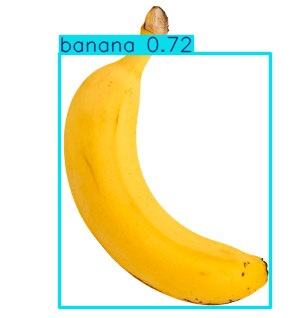

In [ ]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')


**4. Download Model**

Untuk men-deploy hasil model, dilakukan secara lokal menggunakan Anaconda Prompt. Untuk itu, model akan disimpan dalam bentuk file .zip

In [ ]:
# Membuat folder baru bernama my_model yang berisi seluruh hasil train dan test model
!mkdir /content/my_model
!cp /content/runs/detect/train/weights/best.pt /content/my_model/my_model.pt
!cp -r /content/runs/detect/train /content/my_model

# Zip folder
%cd my_model
!zip /content/my_model.zip my_model.pt
!zip -r /content/my_model.zip train
%cd /content

/content/my_model
  adding: my_model.pt (deflated 8%)
  adding: train/ (stored 0%)
  adding: train/train_batch1.jpg (deflated 12%)
  adding: train/results.csv (deflated 60%)
  adding: train/weights/ (stored 0%)
  adding: train/weights/last.pt (deflated 8%)
  adding: train/weights/best.pt (deflated 8%)
  adding: train/R_curve.png (deflated 12%)
  adding: train/train_batch511.jpg (deflated 17%)
  adding: train/labels.jpg (deflated 24%)
  adding: train/train_batch510.jpg (deflated 23%)
  adding: train/val_batch0_labels.jpg (deflated 20%)
  adding: train/confusion_matrix_normalized.png (deflated 28%)
  adding: train/PR_curve.png (deflated 24%)
  adding: train/labels_correlogram.jpg (deflated 40%)
  adding: train/train_batch2.jpg (deflated 10%)
  adding: train/results.png (deflated 7%)
  adding: train/F1_curve.png (deflated 10%)
  adding: train/confusion_matrix.png (deflated 31%)
  adding: train/args.yaml (deflated 53%)
  adding: train/val_batch0_pred.jpg (deflated 19%)
  adding: train/P_cu

In [ ]:
# Download Model
from google.colab import files

files.download('/content/my_model.zip')

# Deploy Model


**1. Membuat dan aktivasi environment**

Pada Anaconda Prompt, kita akan membuat sebuah environment baru bernama yolo-env1. Setelah dibuat, kita aktivasi untuk pindah ke environment tersebut.

In [ ]:
conda create --name yolo-env1 python=3.12 -y
conda activate yolo-env1

**2. Install Ultralytics**

In [ ]:
pip install ultralytics

**3. Berikan lokasi file my_model**

In [ ]:
cd C:\Users\USER\Downloads\fruit_detect\my_model # Sesuaikan lokasi di masing-masing device

**4. Mengambil script untuk deploy model YOLO**

Untuk men-deploy model secara langsung, kita mengambil script yang sudah dibuat dari GitHub. Script diambil menggunakan perintah curl dan disimpan ke file bernama yolo_detect.py

In [ ]:
curl -o yolo_detect.py https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/yolo_detect.py

**5. Buka webcam**

Dari script sebelumnya, YOLO dapat langsung di-deploy menggunakan webcam yang terintegrasi oleh laptop kita.

Model sudah di-deploy dan kita dapat mengecek hasilnya dengan menggunakan contoh buah-buahan secara real-time.

In [ ]:
python yolo_detect.py --model my_model.pt --source usb0 --resolution 640x480

## Screenshot Deploy

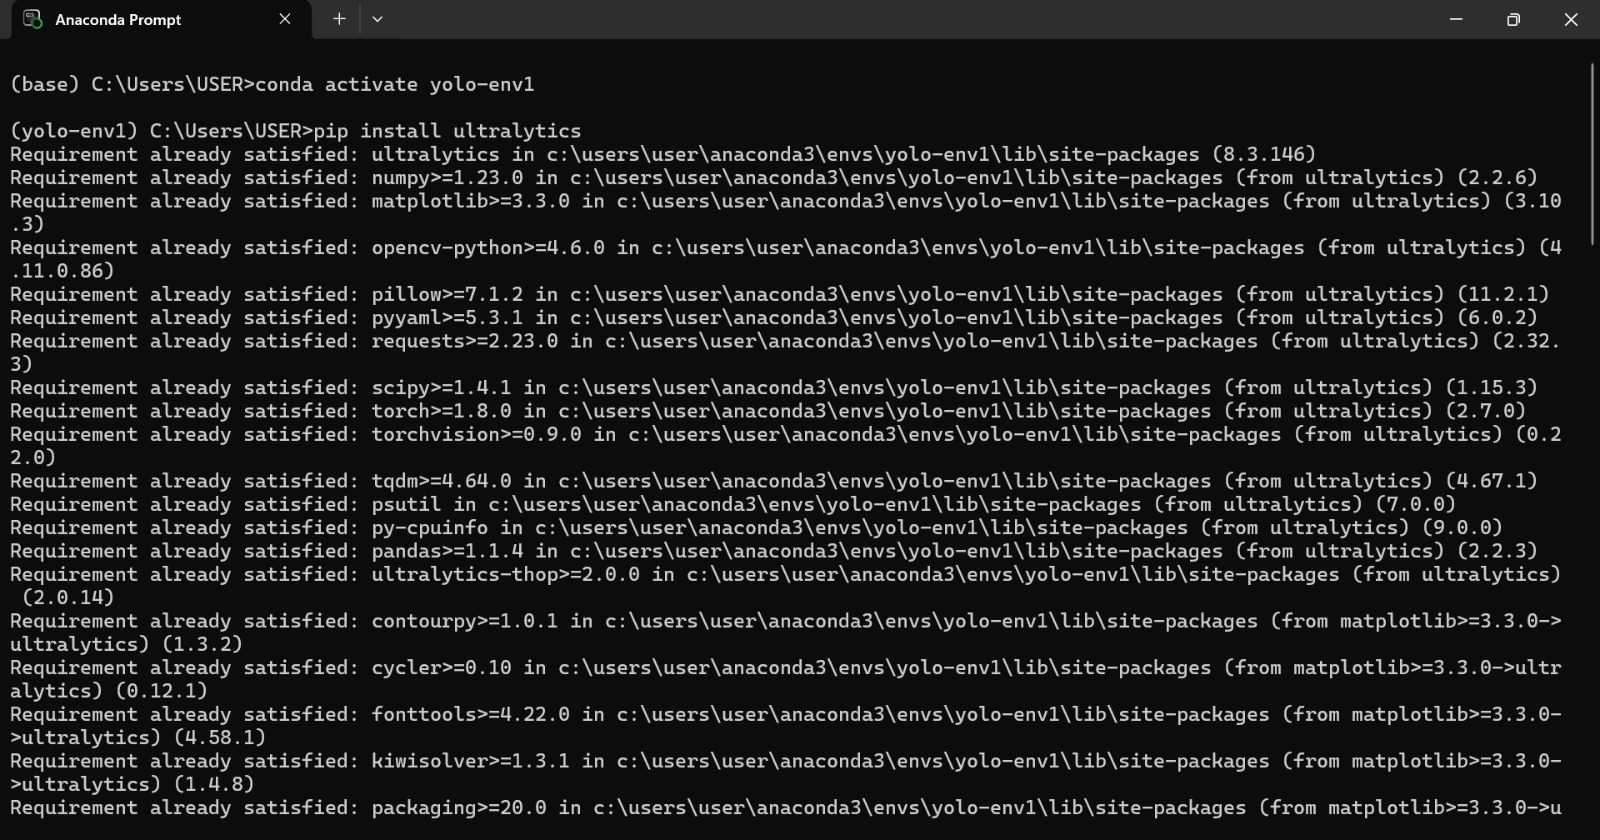

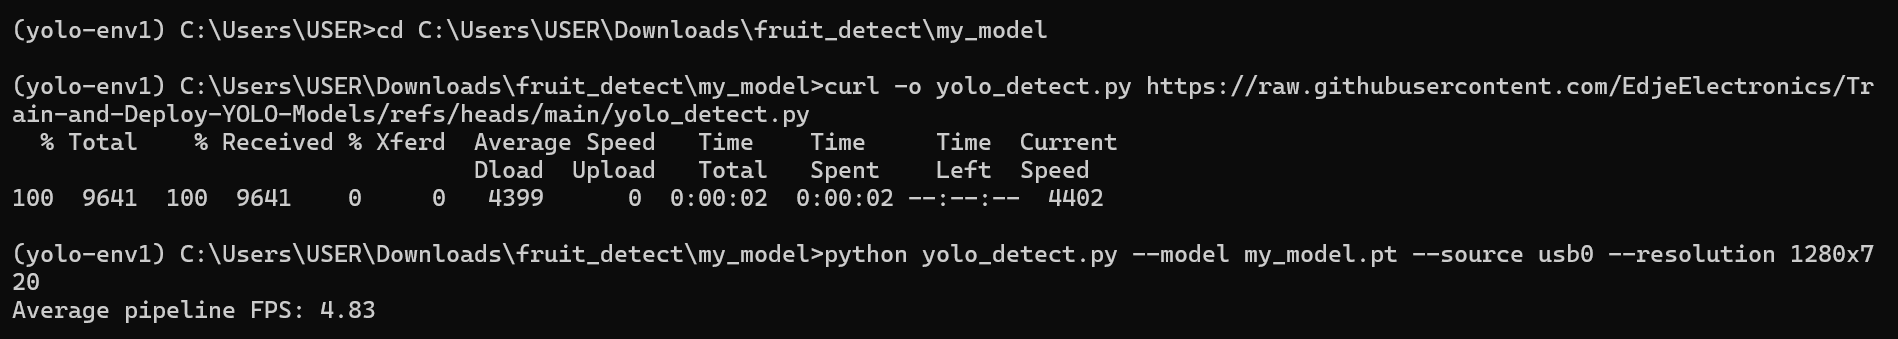

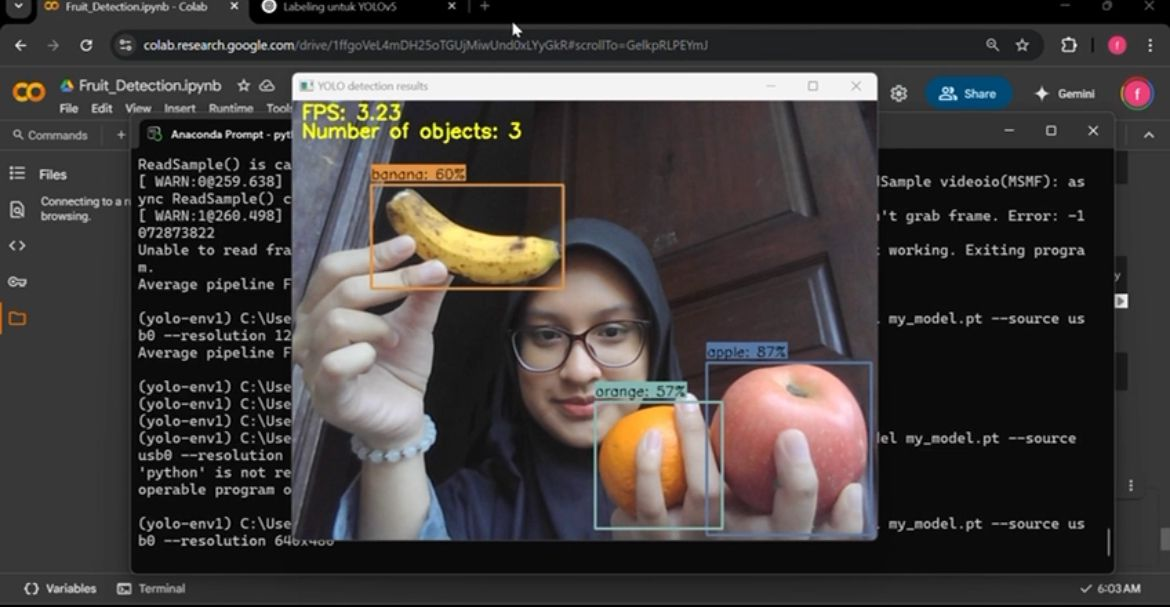